# 4.3 Optimal Scenario Analyses

## Preparations

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime
import random
import pickle
from sklearn.metrics import mean_squared_error
import openpyxl
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading and Preparing Taxi Data
path = ''
df_top20 = pd.read_csv(path+'Data/df_top20.csv')
df_complex_complete = pd.DataFrame()

for i in df_top20.groupby('PULocationID'):
    A = i[1]

    df_complex = pd.concat([A['datetime'], A['PULocationID'], 
                            A['PULocationID'].astype(str)+'-'+A['pickup_day_of_week'].astype(str), 
                            np.cos((A['pickup_hour']*2*np.pi)/24), np.sin((A['pickup_hour']*2*np.pi)/24), 
                            np.cos((A['pickup_hour']*2*np.pi)/12),  np.sin((A['pickup_hour']*2*np.pi)/12), A['count'], 
                            A['count'].shift(1), A['count'].shift(2),A['count'].shift(3), A['count'].shift(4),
                            A['count'].shift(5), A['count'].shift(6), A['count'].shift(7), A['count'].shift(8), 
                            A['count'].shift(9), A['count'].shift(10),A['count'].shift(11), A['count'].shift(12), 
                            A['count'].shift(13), A['count'].shift(14), A['count'].shift(15), A['count'].shift(16), 
                            A['count'].shift(17), A['count'].shift(18), A['count'].shift(19), A['count'].shift(20), 
                            A['count'].shift(21), A['count'].shift(22),   A['count'].shift(23), A['count'].shift(24), 
                            A['count'].shift(168), A['count'].shift(336), A['count'].shift(504), A['count'].shift(672)], 
                           axis = 1)

    df_complex.columns = ['datetime', 'PULocationID', 'categorical', 'cos_hour', 'sin_hour', 'cos_month', 'sin_month', 
                          'y', 'y-1', 'y-2', 'y-3', 'y-4','y-5', 'y-6', 'y-7', 'y-8', 'y-9', 'y-10', 'y-11', 'y-12',
                          'y-13', 'y-14', 'y-15', 'y-16','y-17', 'y-18', 'y-19', 'y-20','y-21', 'y-22', 'y-23', 'y-24', 
                          'y-1w', 'y-2w', 'y-3w', 'y-4w']
    df_complex_complete = df_complex_complete.append(df_complex, ignore_index = True) 

df_final = df_complex_complete.join(pd.get_dummies(df_complex_complete['categorical'])).dropna()
df_final.sort_values(['PULocationID', 'datetime'], inplace = True)

In [3]:
# Metrics
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

def rmse(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return(np.sqrt(mean_squared_error(actual,forecast)))

In [4]:
# XGBoost
params = [0.06759574377750831,82,8,3.247253370691017, 0.04770505824520567,0.6854091260991332, 0.8344206263318037]

In [5]:
# prediction models
def naive(X):
    return X['y-1']

def xgboost(X):
    return xgb_model.predict(X.values.reshape(1,172), validate_features = False)[0]

In [6]:
# MAB Procedure
class MAB(object):
    """Base selector
    
    Args:
        models (dict): a dictionary of models from which the selector must choose at every
            call to ``select``.
        learning_strategy (func): a funct that represents the learning strategy utilized
            by the selector at every call to ``select``.
    """
    def __init__(self, models, learning_strategy):
        self.models = models
        self.ls = learning_strategy
        self.scores = dict.fromkeys(models.keys(), [1])
        self.history_model = []
        self.history_score = []
        self.history_pred = []
        self.history_y = []
        
        # change for zone specifity
        self.zone = [9999]

    def select(self, **kwargs):
        return max(self.scores, key=lambda i: self.ls([i, self.scores[i], self.history_model], **kwargs))
        
    def procedure(self, series, **kwargs):
        self.zone.append(series.loc['PULocationID'])
        X = series.iloc[~series.index.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
        y = series['y']
        
        if self.zone[-1] != self.zone[-2]:
            self.scores = dict.fromkeys(models.keys(), [1])
        
        random_number = random.random()
        model = self.select(random_number = random_number, **kwargs)
        pred = max(0, self.models[model](X))
        percentage_error = np.abs(y-pred)/y
        percentage_accur = 1 - percentage_error
        self.scores[model] = self.scores[model] + [percentage_accur]
        
        self.history_model.append(model)
        self.history_pred.append(pred)
        self.history_score.append(percentage_accur)
        self.history_y.append(y)
        
    def execute(self, df, **kwargs):
        df.apply(self.procedure, **kwargs, axis = 1)

In [10]:
# Strategies for one of the models only
def ls_xgboost(list, random_number):
    if list[0] == 'xgb':
        return 1
    else:
        return 0
    
def ls_naive(list, random_number):
    if list[0] == 'naive':
        return 1
    else:
        return 0

# learning strategies
## Epsilon-greedy
def epsg(list, random_number, epsilon = 0.15, epoch_length = 168):
    if (random_number <= epsilon):
        r = random.random()
        return r
    
    else:
        model = list[0]
        score_list = list[1]
        history_models = list[2]
        
        epoch = (len(history_models)) % epoch_length
        if epoch == 0:
            epoch = epoch_length
        occurence = history_models[-epoch:].count(model)
        epoch_mean = np.mean(score_list[-occurence:])
        
        return epoch_mean

## Upper Confidence Boundary
def ucb(list, random_number, alpha = 0.5, sw_length = 168):
    model = list[0]
    score_list = list[1]
    history_models = list[2]

    N = max(history_models[-sw_length:].count(model), 1)
    average_accuracy = np.mean(score_list[-N:])
    v = len(history_models)
    
    padding = np.sqrt(alpha * np.log(min(v, sw_length)) / N)
    return average_accuracy + padding

In [15]:
# Custom Colour Map
R = np.linspace(0, .5234375)
G = np.linspace(0, .734375)
B = np.linspace(0, .14453125)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict = LinearSegmentedColormap('cdict', cdict)

R = np.linspace(.5234375, 0)
G = np.linspace(.734375, 0)
B = np.linspace(.14453125, 0)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict_r = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict_r = LinearSegmentedColormap('cdict_r', cdict_r)

In [16]:
# Diebold-Mariano Test
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [11]:
xgb_only = pickle.load(open(path+"Results/xgb_only.dat", "rb"))
naive_only = pickle.load(open(path+"Results/naive_only.dat", "rb"))

In [13]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

xgb_preds = []
naive_preds = []

for i in range(len(xgb_only)):
    xgb_year_preds = xgb_only[i].history_pred
    naive_year_preds = naive_only[i].history_pred
    xgb_preds.append(xgb_year_preds)
    naive_preds.append(naive_year_preds)

df_test.sort_values(['year', 'PULocationID', 'datetime'], inplace = True)
df_test['xgb'] = [item for elem in xgb_preds for item in elem]
df_test['naive'] = [item for elem in naive_preds for item in elem]

## Switching Behaviour

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

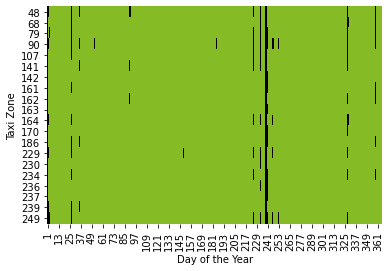

In [24]:
smape_naive_only = []
smape_xgb_only = []
location = []
doy = []
for title, group in df_test[df_test['year']==2011].groupby(['PULocationID', 'doy']):
    location.append(title[0])
    doy.append(title[1])
    smape_naive_only.append(smape(group['y'],group['naive']))
    smape_xgb_only.append(smape(group['y'],group['xgb']))

naive_best = [i for i in range(len(smape_naive_only)) if smape_naive_only[i] < smape_xgb_only[i]]
location_naive_best = [location[j] for j in naive_best]
doy_naive_best = [doy[j] for j in naive_best]
naive_best_loc_doy_smape = [str(location_naive_best[j])+' '+str(doy_naive_best[j]) for j in range(len(location_naive_best))]

rows = np.unique(location)
cols = np.unique(doy)
data_heatmap = pd.DataFrame(0, index = rows, columns = cols)

for i in range(len(location)):
    if str(location[i])+' '+str(doy[i]) in naive_best_loc_doy_smape:
        data_heatmap.loc[location[i], doy[i]] = 1

custom_cmap = cm.colors.ListedColormap(['#86BC25', '#000000'])

ax = sns.heatmap(data_heatmap, cbar = False, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

[Text(0.5, 15.0, 'Day of the Year'), Text(33.0, 0.5, 'Taxi Zone')]

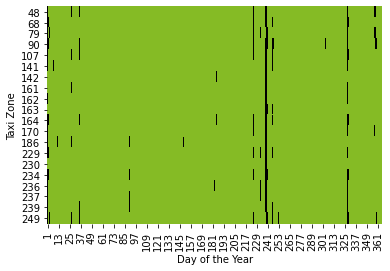

In [23]:
rmse_naive_only = []
rmse_xgb_only = []
location = []
doy = []
for title, group in df_test[df_test['year']==2011].groupby(['PULocationID', 'doy']):
    location.append(title[0])
    doy.append(title[1])
    rmse_naive_only.append(rmse(group['y'],group['naive']))
    rmse_xgb_only.append(rmse(group['y'],group['xgb']))

naive_best = [i for i in range(len(rmse_naive_only)) if rmse_naive_only[i] < rmse_xgb_only[i]]
location_naive_best = [location[j] for j in naive_best]
doy_naive_best = [doy[j] for j in naive_best]
naive_best_loc_doy_rmse = [str(location_naive_best[j])+' '+str(doy_naive_best[j]) for j in range(len(location_naive_best))]

rows = np.unique(location)
cols = np.unique(doy)
data_heatmap_rmse = pd.DataFrame(0, index = rows, columns = cols)

for i in range(len(location)):
    if str(location[i])+' '+str(doy[i]) in naive_best_loc_doy_rmse:
        data_heatmap_rmse.loc[location[i], doy[i]] = 1

custom_cmap = cm.colors.ListedColormap(['#86BC25', '#000000'])

ax = sns.heatmap(data_heatmap_rmse, cbar = False, cmap = cdict_r)
ax.set(xlabel = 'Day of the Year', ylabel = 'Taxi Zone')

In [19]:
df_year = df_test[df_test['year']==2011]
df_naive_better = df_year[df_year['PULocationID'].astype(str).str.cat(df_year['doy'].astype(str), sep = ' ').isin(naive_best_loc_doy_smape)]
pred_optimal_smape = []

for i in range(len(df_year)):
    if df_year.index[i] in df_naive_better.index:
        pred_optimal_smape.append(df_year['naive'].values[i])
  
    else:
        pred_optimal_smape.append(df_year['xgb'].values[i])

In [20]:
df_year = df_test[df_test['year']==2011]
df_naive_better = df_year[df_year['PULocationID'].astype(str).str.cat(df_year['doy'].astype(str), sep = ' ').isin(naive_best_loc_doy_rmse)]
pred_optimal_rmse = []

for i in range(len(df_year)):
    if df_year.index[i] in df_naive_better.index:
        pred_optimal_rmse.append(df_year['naive'].values[i])
  
    else:
        pred_optimal_rmse.append(df_year['xgb'].values[i])

In [21]:
print(smape(df_year['y'], pred_optimal_smape))
print(rmse(df_year['y'], pred_optimal_smape))
print(smape(df_year['y'], pred_optimal_rmse))
print(rmse(df_year['y'], pred_optimal_rmse))

10.527785469128105
70.53840850196416
10.56077193229273
70.3707451990412


In [29]:
descriptives_days = data_heatmap.describe()
descriptives_days.sort_values('mean', axis = 1, ascending = False)

,1,239,240,328,27,241,233,226,359,2,...,119,127,126,125,124,123,122,121,120,365
count,20.0,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,1.0,1.0,1.0,0.600000,0.600000,0.550000,0.550000,0.450000,0.400000,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.502625,0.502625,0.510418,0.510418,0.510418,0.502625,0.470162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


smape xgb on day 239 240 are 59.176780818426195
smape naive on day 239 240 are 33.68503695243362
rmse xgb on day 239 240 are 68.59796124533295
rmse naive on day 239 240 are 49.9005532774067


<AxesSubplot:xlabel='Time', ylabel='Trips'>

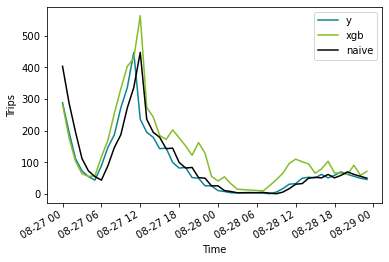

In [30]:
# Hurricane Irene 2011
day = 239
zone = 237
df_year_zone = df_year[(df_year['PULocationID']==zone)]

print('smape xgb on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('smape naive on day', day, day + 1, 'are', 
      smape(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
            df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))
print('rmse xgb on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['xgb']))
print('rmse naive on day', day, day + 1, 'are', 
      rmse(df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['y'], 
           df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)]['naive']))

df_year_zone[(df_year_zone['doy']==day)|(df_year_zone['doy']==day+1)].plot(x = 'datetime', 
                                                                           y = ['y', 'xgb', 'naive'], 
                                                                           legend = True, xlabel = 'Time', 
                                                                           ylabel = 'Trips', 
                                                                           color = ['#0D8390', '#86BC25', '#000000'], 
                                                                           style = ['-', '-', '-'])

## Predictive Performance

In [31]:
yearly_xgb_smape = []
yearly_xgb_rmse = []
yearly_naive_smape = []
yearly_naive_rmse = []
yearly_titles = []
for title, group in df_test.groupby(['year']):
    yearly_titles.append(title)
    yearly_xgb_smape.append(smape(group['xgb'], group['y']))
    yearly_xgb_rmse.append(rmse(group['xgb'], group['y']))
    yearly_naive_smape.append(smape(group['naive'], group['y']))
    yearly_naive_rmse.append(rmse(group['naive'], group['y']))

yearly = pd.DataFrame({'date': yearly_titles, 
                       'xgb_smape':yearly_xgb_smape, 
                       'naive_smape':yearly_naive_smape, 
                       'xgb_rmse':yearly_xgb_rmse, 
                       'naive_rmse':yearly_naive_rmse})

In [32]:
print(yearly.to_latex( float_format="%.2f", index = False))

\begin{tabular}{rrrrr}
\toprule
 date &  xgb\_smape &  naive\_smape &  xgb\_rmse &  naive\_rmse \\
\midrule
 2011 &      10.81 &        26.20 &     70.78 &      150.49 \\
 2012 &       9.77 &        26.41 &     67.84 &      153.18 \\
 2013 &      10.00 &        26.61 &     68.12 &      151.45 \\
 2014 &      10.03 &        26.18 &     65.43 &      142.40 \\
 2015 &      10.55 &        26.12 &     61.23 &      126.60 \\
 2016 &      11.27 &        26.19 &     57.80 &      115.55 \\
 2017 &      11.61 &        26.60 &     52.00 &      102.05 \\
 2018 &      11.89 &        27.43 &     47.74 &       94.17 \\
 2019 &      13.01 &        28.55 &     42.19 &       79.91 \\
 2020 &      51.26 &        39.01 &     28.71 &       39.17 \\
\bottomrule
\end{tabular}



In [33]:
print(smape(df_test['y'], df_test['xgb']), smape(df_test['y'], df_test['naive']))
print(rmse(df_test['y'], df_test['xgb']), rmse(df_test['y'], df_test['naive']))

14.861623287025488 27.882354085027615
57.72512845788117 121.03608074203618


In [36]:
## SMAPE when optimal selection and hurricane not a problem
pred_realistic = []
models_realistic = []

for i in range(len(df_year)):
    if (df_year['doy'].iloc[i] == 239) | (df_year['doy'].iloc[i] == 240):
        pred_realistic.append(df_year['naive'].values[i])
        models_realistic.append('naive')
    
    else:
        pred_realistic.append(df_year['xgb'].values[i])
        models_realistic.append('xgb')
    
print('smape huricane selection', smape(df_year['y'], pred_realistic))
print('smape huricane selection', rmse(df_year['y'], pred_realistic))

smape huricane selection 10.604129548804178
smape huricane selection 70.68904715964086


In [40]:
pickle.dump(models_realistic, open(path+'Results/model_hurricane.dat', "wb"))
pickle.dump(pred_realistic, open(path+'Results/pred_hurricane.dat', "wb"))

In [38]:
print('XGB vs Hurricane', dm_test(df_year['y'], df_year['xgb'],  pred_realistic))
print('SMAPE vs RMSE', dm_test(df_year['y'], pred_optimal_smape,  pred_optimal_rmse))
print('SMAPE vs Hurricane', dm_test(df_year['y'], pred_optimal_smape,  pred_realistic))
print('RMSE vs Hurricane', dm_test(df_year['y'], pred_optimal_rmse,  pred_realistic))
print('XGB vs RMSE', dm_test(df_year['y'], pred_optimal_rmse,  df_year['xgb']))
print('XGB vs SMAPE', dm_test(df_year['y'], pred_optimal_smape,  df_year['xgb']))

XGB vs Hurricane dm_return(DM=3.20647177769196, p_value=0.0013439759972307614)
SMAPE vs RMSE dm_return(DM=3.7334605786597073, p_value=0.000188926492946738)
SMAPE vs Hurricane dm_return(DM=-3.054665343974819, p_value=0.0022534561642756053)
RMSE vs Hurricane dm_return(DM=-6.468492723488502, p_value=9.924462799794281e-11)
XGB vs RMSE dm_return(DM=-8.875362564710722, p_value=7.03415853204004e-19)
XGB vs SMAPE dm_return(DM=-4.237428121742109, p_value=2.2621019939779265e-05)


In [39]:
print('naive vs xgb', sum(np.array(df_year['naive']) != np.array(df_year['xgb']))/len(pred_realistic)*100)
print('smape vs xgb', sum(np.array(pred_optimal_smape) != np.array(df_year['xgb']))/len(pred_realistic)*100)
print('rmse vs xgb', sum(np.array(pred_optimal_rmse) != np.array(df_year['xgb']))/len(pred_realistic)*100)
print('hurricane vs xgb', sum(np.array(pred_realistic) != np.array(df_year['xgb']))/len(pred_realistic)*100)

naive vs xgb 99.99942908362213
smape vs xgb 2.1106778490154547
rmse vs xgb 1.9599559252556278
hurricane vs xgb 0.5349486460718099
